In [ ]:
!pip install networkx python-louvain plotly

In [ ]:
#!pip install networkx==2.8.8

In [ ]:
# Import needed libraries

from pyspark.sql.functions import input_file_name, regexp_extract, col
from pyspark.sql import SparkSession
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score, mutual_info_score

In [ ]:
# First, we start uploading the Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
spark = SparkSession.builder \
    .appName("Combine CSVs") \
    .getOrCreate()

In [ ]:
file_pattern = "/content/drive/MyDrive/data/networks/*-*-*.csv"
df = spark.read.csv(file_pattern, header=True, inferSchema=True)

In [ ]:
# Enable the capture of file name
spark.conf.set("spark.sql.sources.partitionColumnTypeInference.enabled", "false")

# Read the files and add a column with the file name
df = df.withColumn("filename", input_file_name())

# Extract the date from the filename and add it as a column
df = df.withColumn("date", regexp_extract("filename", r'(\d{4}-\d{1,2}-\d{1,2})', 1))

# Drop the filename column
df = df.drop('filename')

In [ ]:
# Filter rows where the date starts with '2015-1-'
df_2015_1 = df.filter(col("date").startswith("2015-1-"))

In [ ]:
pandas_df = df_2015_1.toPandas()

In [ ]:
# Initialize a directed graph since money flow is unidirectional
G = nx.DiGraph()

# Iterate through the DataFrame and add edges
for index, row in pandas_df.iterrows():
    # Add an edge with attributes
    G.add_edge(row['Source'], row['Target'], weight=row['value'])

## Experiment 1: Compute important elements from the graph

In [ ]:
file = None  # open('out', 'w')
plotOn = True

In [ ]:
def compute_centrality(g):
    nodes_degrees = nx.degree_centrality(g)
    # nodes_degrees = nx.closeness_centrality(g)
    # nodes_degrees = nx.betweenness_centrality(g)

    max_centrality = max(nodes_degrees, key=nodes_degrees.get)
    print('\n\tNode with Max number of Edges: ', max_centrality,
          ' || Degree: ', nodes_degrees[max_centrality], file=file)

    return max_centrality

In [ ]:
def print_node_degrees(g, node):
    print('\tDegrees data for node ', node, file=file)
    print('\t\tMost important node In-Degree:', g.in_degree(node),
          ' || Weighted: ', g.in_degree(node, weight='weight'), file=file)
    print('\t\tMost important node Out-Degree:', g.out_degree(node),
          ' || Weighted: ', g.out_degree(node, weight='weight'), file=file)
    print('\t\tMost important node Total-Degree:', g.degree(node),
          ' || Weighted: ', g.degree(node, weight='weight'), file=file)

In [ ]:
def plot_distribution(values, label):
    values_count = collections.Counter(values)
    val, cnt = zip(*values_count.items())

    fig, ax = plt.subplots()
    plt.bar(val, cnt, width=0.80, color='b')

    plt.title(label + " Histogram")
    plt.ylabel("Count")
    plt.xlabel(label)
    ax.set_xticks([v + 0.4 for v in val])
    ax.set_xticklabels(val)
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.show()

In [ ]:
def compute_component(comps):
    print('\t\tNumber of components:', len(comps), file=file)

    diameters = [nx.diameter(comp.to_undirected()) for comp in comps]
    print('\t\tDiameter max:', max(diameters), file=file)
    print('\t\tDiameter min:', min(diameters), file=file)
    print('\t\tDiameter avg:', sum(diameters) / len(diameters), file=file)
    if plotOn:
        plot_distribution(diameters, 'diameter')

    giant_comp = max(comps, key=len)  # This is a subgraph that we have to study
    compute_centrality(giant_comp)
    print('\tGiant component:', file=file)
    print('\t\tNumber of nodes:', giant_comp.number_of_nodes(), file=file)
    print('\t\tNumber of edges:', giant_comp.number_of_edges(), file=file)

    indegree = dict(giant_comp.in_degree())
    outdegree = dict(giant_comp.out_degree())
    degree = dict(giant_comp.degree())
    if plotOn:
        plot_distribution(indegree.values(), 'indegree component')
        plot_distribution(outdegree.values(), 'outdegree component')
        plot_distribution(degree.values(), 'degree')

    print('\t\tMost important node is: \n\t\t\tIn-Degree ', max(indegree), ' || Out-Degree: ', max(outdegree),
          ' || Total Degree: ', max(degree), file=file)

    print("\t\tDensity:", nx.density(giant_comp), file=file)
    print('\t\tAverage clustering', nx.average_clustering(nx.Graph(giant_comp)), file=file)

    return giant_comp

In [ ]:
def do_general_computations(g):
    print('Bitcoin Alpha Graph:', file=file)
    print('\tNumber of nodes:', g.number_of_nodes(), file=file)
    print('\tNumber of edges:', g.number_of_edges(), file=file)
    print('\tNumber of self-loops:', nx.number_of_selfloops(g), file=file)
    print('\tLargest component size:', len(max(nx.connected_components(g.to_undirected()), key=len)), file=file)

    max_centrality = compute_centrality(g)
    print_node_degrees(g, max_centrality)

    print('\n\tNumber of triangles:', sum(nx.triangles(g.to_undirected()).values()) / 3, file=file)
    print('\tAverage clustering:', nx.average_clustering(g.to_undirected()), file=file)

    print('\n\tStrongly connected components:', file=file)
    connected_comps_strong = list(g.subgraph(c) for c in nx.strongly_connected_components(g))
    strong_giant = compute_component(connected_comps_strong)
    print('\tAverage shortest path length', nx.average_shortest_path_length(strong_giant), file=file)

    print('\n\tWeakly connected components:', file=file)
    connected_comps_weak = list(g.subgraph(c) for c in nx.weakly_connected_components(g))
    weak_giant = compute_component(connected_comps_weak)


Bitcoin Alpha Graph:
	Number of nodes: 4003
	Number of edges: 20627
	Number of self-loops: 0
	Largest component size: 3993

	Node with Max number of Edges:  ePay.info_CoinJoinMess  || Degree:  0.33558220889555224
	Degrees data for node  ePay.info_CoinJoinMess
		Most important node In-Degree: 470  || Weighted:  1069924315673
		Most important node Out-Degree: 873  || Weighted:  233878916540519
		Most important node Total-Degree: 1343  || Weighted:  234948840856192

	Number of triangles: 88583.0
	Average clustering: 0.383547425348621

	Strongly connected components:
		Number of components: 1672
		Diameter max: 6
		Diameter min: 0
		Diameter avg: 0.010167464114832535


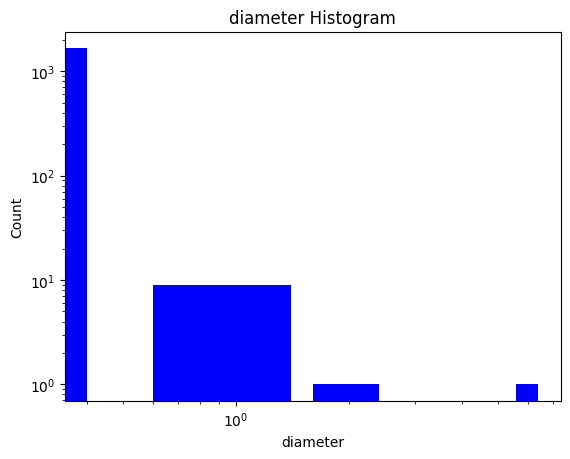


	Node with Max number of Edges:  ePay.info_CoinJoinMess  || Degree:  0.4732758620689655
	Giant component:
		Number of nodes: 2321
		Number of edges: 16210


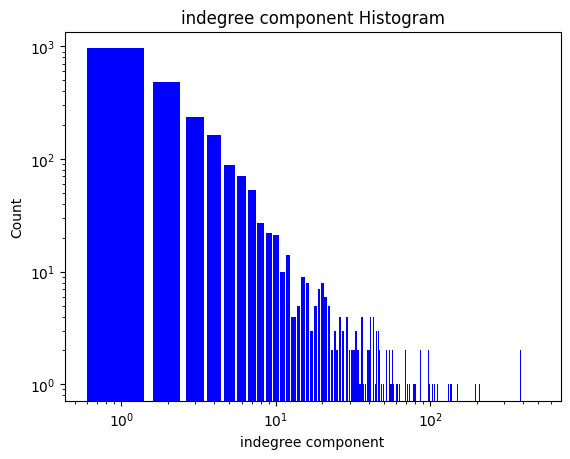

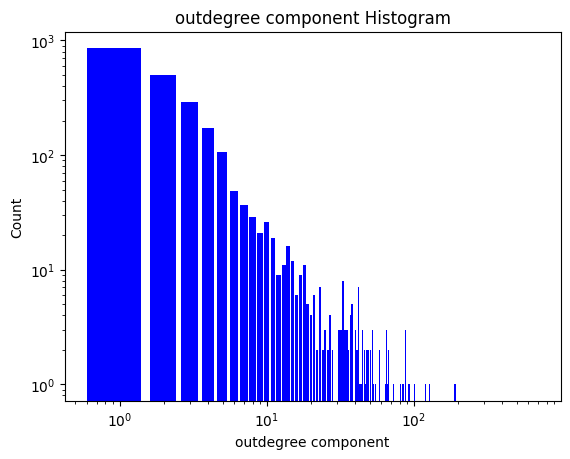

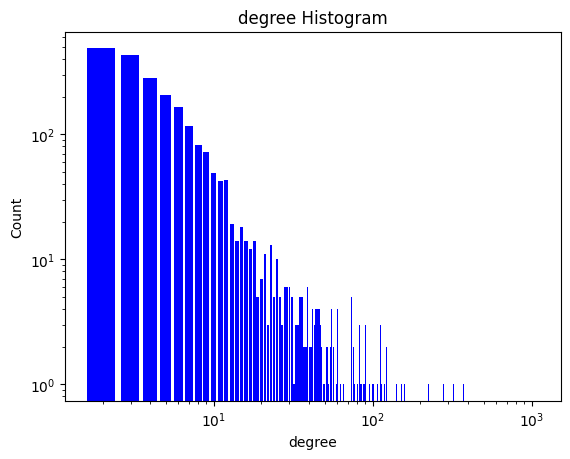

		Most important node is: 
			In-Degree  ePay.info_CoinJoinMess  || Out-Degree:  ePay.info_CoinJoinMess  || Total Degree:  ePay.info_CoinJoinMess
		Density: 0.0030103700842383633
		Average clustering 0.5357088176086279
	Average shortest path length 3.4990008765543985

	Weakly connected components:
		Number of components: 6
		Diameter max: 8
		Diameter min: 1
		Diameter avg: 2.1666666666666665


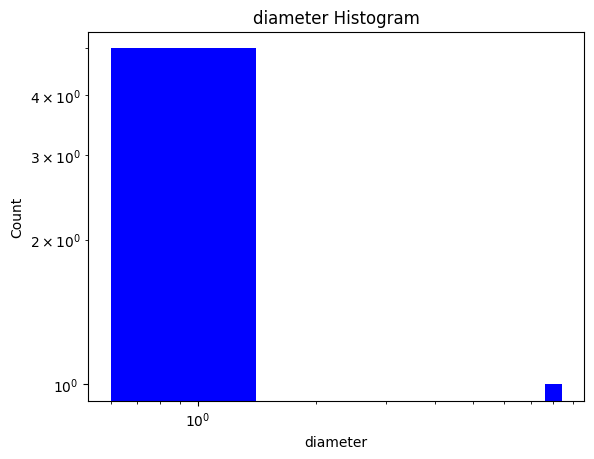


	Node with Max number of Edges:  ePay.info_CoinJoinMess  || Degree:  0.33642284569138275
	Giant component:
		Number of nodes: 3993
		Number of edges: 20621


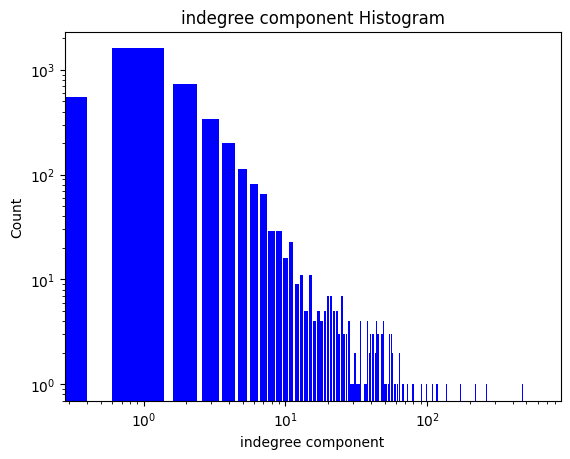

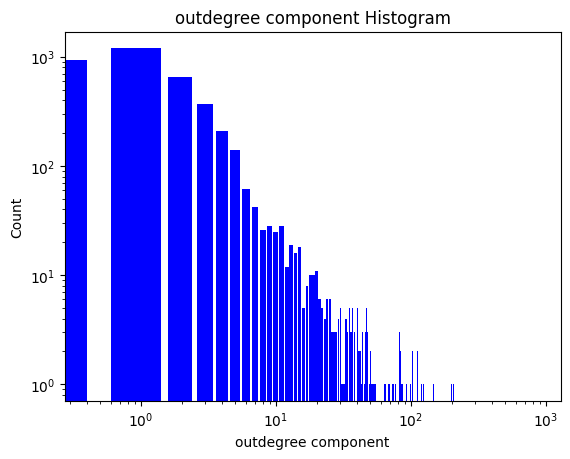

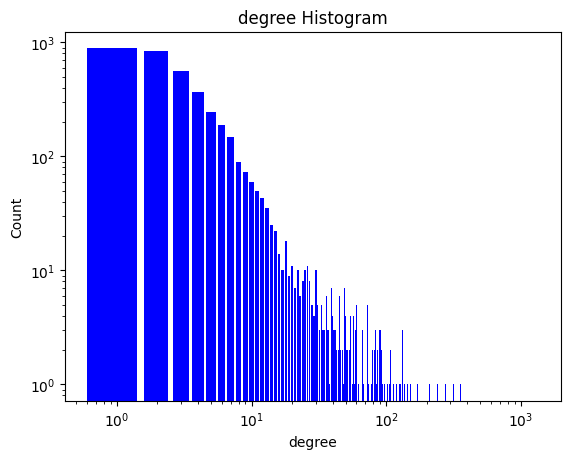

		Most important node is: 
			In-Degree  ePay.info_CoinJoinMess  || Out-Degree:  ePay.info_CoinJoinMess  || Total Degree:  ePay.info_CoinJoinMess
		Density: 0.0012936591941709616
		Average clustering 0.3845079748736614


In [ ]:
do_general_computations(G)

## Experiment 2: Communities Analysis

In [ ]:
# We compute the communities using Louvain and Greedy Modularity
louvain_communities = tuple(sorted(c) for c in nx.community.louvain_communities(G))
greedy_modularity_communities = tuple(sorted(c) for c in nx.community.greedy_modularity_communities(G))

In [ ]:
# Convert the communities to lists of discrete labels
louvain_labels = [i for i, comm in enumerate(louvain_communities) for node in comm]
greedy_modularity_labels = [i for i, comm in enumerate(greedy_modularity_communities) for node in comm]

In [ ]:
def custom_draw(G, n):

  # Step 1: Remove Nodes with degree less than n
  nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < n]
  G.remove_nodes_from(nodes_to_remove)

  # Step 2: Extract Largest Component of the Graph
  largest_cc = max(nx.connected_components(G), key=len)
  G_largest_cc = G.subgraph(largest_cc)

  # Step 2: Detect communities using the Louvain algorithm
  partition = list(nx.community.louvain_communities(G_largest_cc))

  # Step 3: Calculate betweenness centrality
  betweenness_centrality = nx.centrality.betweenness_centrality(G_largest_cc)

  # Step 4: Assign node color
  node_color = []
  for node in G_largest_cc.nodes:
    for i in range(len(partition)):
      if node in partition[i]:
        node_color.append(i)

  # Step 5: Draw the custom graph
  pos = nx.spring_layout(G_largest_cc)
  node_size = [10000 * betweenness_centrality[node] for node in G_largest_cc.nodes]

  nx.draw(G_largest_cc, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.rainbow)
  plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from community import community_louvain

def custom_draw_dynamic(G, n):
    # Step 1: Remove Nodes with degree less than n
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < n]
    G.remove_nodes_from(nodes_to_remove)

    # Step 2: Extract Largest Component of the Graph
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest_cc = G.subgraph(largest_cc)

    # Step 3: Detect communities using the Louvain algorithm
    partition = community_louvain.best_partition(G_largest_cc)

    # Step 4: Position the nodes using one of the NetworkX layouts
    pos = nx.spring_layout(G_largest_cc)

    # Step 5: Extract node and edge positions from the layout
    edge_x = []
    edge_y = []
    for edge in G_largest_cc.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Step 6: Create a trace for the edges
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Step 7: Create a trace for the nodes
    node_x = []
    node_y = []
    node_color = []
    for node in G_largest_cc.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(partition[node])  # Color node based on its community

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=node_color,  # Assign color based on community
            size=10,
            colorbar=dict(
                thickness=15,
                title='Community Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Step 8: Add node metadata to hoverinfo
    node_text = []
    for node in G_largest_cc.nodes():
        node_text.append('Node: {}<br># of connections: {}'.format(node, len(list(G_largest_cc.neighbors(node)))))

    node_trace.text = node_text

    # Step 9: Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                   layout=go.Layout(
                       title='<br>Network graph made with Python',
                       titlefont_size=16,
                       showlegend=False,
                       hovermode='closest',
                       margin=dict(b=20,l=5,r=5,t=40),
                       annotations=[ dict(
                           text="Python code: <a href='https://www.plotly.com/'> Plotly</a>",
                           showarrow=False,
                           xref="paper", yref="paper",
                           x=0.005, y=-0.002 ) ],
                       xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                       yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                       )

    # Step 10: Display the figure
    fig.show()

# Use the function with your graph G and a threshold n
# custom_draw_dynamic(G, n)


In [ ]:
custom_draw_dynamic(G.to_undirected(), 10)

## Experiment 3: Draw Graph

In [ ]:
# Static Option

def graph_drawing(g):
  nx.draw_networkx(g, node_size=50, font_size=2, arrowsize=3, node_color='b')
  plt.show()

  #pos = nx.spring_layout(G)  # positions for all nodes
  # nodes
  #nx.draw_networkx_nodes(G, pos, node_size=20)
  # edges
  #nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
  #plt.show()

In [ ]:
graph_drawing(G)

In [ ]:
# Interactive Option

# Position the nodes using one of the NetworkX layouts
pos = nx.spring_layout(G)

# Extract node and edge positions from the layout
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Create a trace for the edges
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create a trace for the nodes
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # Color scale options
        # 'Greys', 'YlGnBu', 'Greens', 'YlOrRd', 'Bluered', 'RdBu',
        # 'Reds', 'Blues', 'Picnic', 'Rainbow', 'Portland', 'Jet',
        # 'Hot', 'Blackbody', 'Earth', 'Electric', 'Viridis', 'Cividis'
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Add node metadata to hoverinfo
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://www.plotly.com/'> Plotly</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Display the figure
fig.show()
